In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load the full scan

In [2]:
fc = FileChooser('/sf/alvra/data/p18938/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18938/raw/scan_info', filename='', show_hidden='False')

In [54]:
quantile_corr = 0.1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero117]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

Energy_eV = np.asarray(Energy_eV)
print(Energy_eV)

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

for i, step in enumerate(scan):
    try:
        check_files_and_data(step)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]

        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

        IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
        DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm

        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)

        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    except:
        Energy_eV = np.delete(Energy_eV, i)
    
    clear_output(wait=True)
    print ('Step {} of {}: Processed {}'.format(i+1, len(scan.files), filename))
    print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

minlen = min(len(i) for i in Pump_probe)
def cut(arr, minlen):
    return np.array([i[:minlen] for i in arr])

DataFluo_pump = cut(DataFluo_pump, minlen)
DataFluo_unpump = cut(DataFluo_unpump, minlen)
Pump_probe = cut(Pump_probe, minlen)

print ("Job done!")


Step 61 of 61: Processed run_035211
correlation = -0.9820146326675434
Job done!


<IPython.core.display.Javascript object>


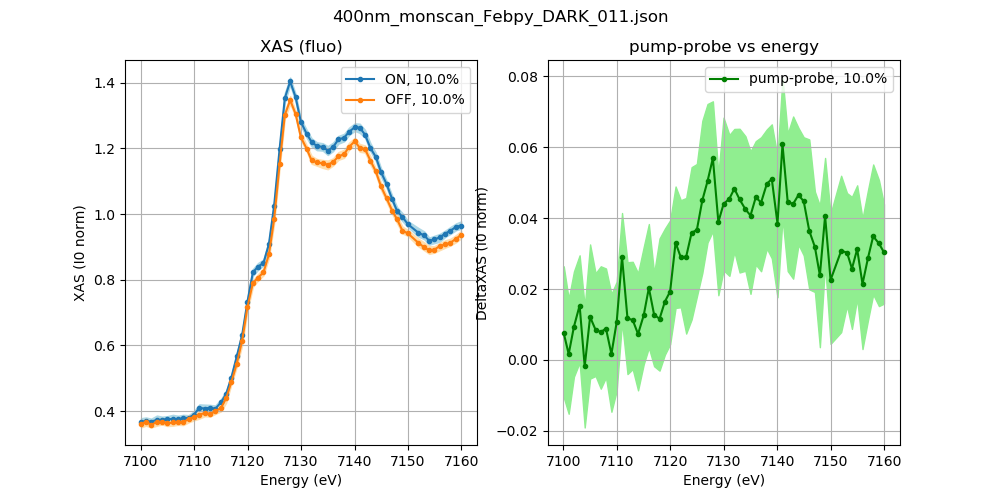

In [55]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_pump = -DataFluo_pump[:,0]
err_low_pump = -DataFluo_pump[:,1]
err_high_pump = -DataFluo_pump[:,2]
XAS_unpump = -DataFluo_unpump[:,0]
err_low_unpump = -DataFluo_unpump[:,1]
err_high_unpump = -DataFluo_unpump[:,2]
XAS_pump_probe = -Pump_probe[:,0]
err_low_pump_probe = -Pump_probe[:,1]
err_high_pump_probe = -Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, XAS_pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Energy_eV,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Energy (eV)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs energy')
plt.legend(loc="best")
plt.grid()

plt.show()



In [49]:
Pump_probe_100fs_mod1 = Pump_probe.copy()

<IPython.core.display.Javascript object>


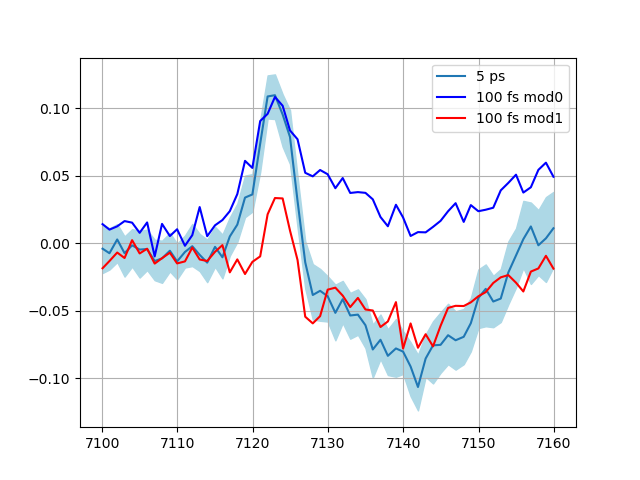

In [50]:
plt.figure()
plt.plot(Energy_eV, -Pump_probe_5ps[:,0], label='5 ps')
plt.fill_between(Energy_eV,-Pump_probe_5ps[:,1], -Pump_probe_5ps[:,2], color='lightblue')

plt.plot(Energy_eV, -Pump_probe_100fs_mod0[:,0], label='100 fs mod0', color = 'blue')
plt.plot(Energy_eV, -Pump_probe_100fs_mod1[:,0], label='100 fs mod1', color = 'red')
#plt.fill_between(Energy_eV,-Pump_probe[:,1], -Pump_probe[:,2], color='lightgreen')

plt.legend(loc='best')
plt.grid()
plt.show()

## Load files in a loop

In [44]:
import glob

datafiles = []
for file in glob.glob('/sf/alvra/data/p18938/raw/scan_info/400nm_monoscan_Febpy_*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:2]+datafiles[3:]
patch

['/sf/alvra/data/p18938/raw/scan_info/400nm_monoscan_Febpy_001.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_monoscan_Febpy_002.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_monoscan_Febpy_004.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_monoscan_Febpy_005.json']

In [47]:
quantile_corr = 0.1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero117]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
from sfdata import SFScanInfo

DataFluo_pump_all = []
DataFluo_unpump_all = []
Pump_probe_all = []

Energy_eV_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    Energy_eV = scan.readbacks

    Energy_eV = np.asarray(Energy_eV)
    
    DataFluo_pump = []
    DataFluo_unpump = []
    err_DataFluo_pump = []
    err_DataFluo_unpump = []

    Pump_probe = []
    err_Pump_probe = []

    for i, step in enumerate(scan):
        try:
            check_files_and_data(step)
            clear_output(wait=True)
            filename = scan.files[i][0].split('/')[-1].split('.')[0]
            print (json_file.split('/')[-1])
            print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

            resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

            IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
            IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
            DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
            DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

            DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
            DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
            Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm

            df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
            df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
            df_pump_probe = pd.DataFrame(Pump_probe_shot)

            DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
            DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        except:
            Energy_eV = np.delete(Energy_eV, i)

    DataFluo_pump = np.asarray(DataFluo_pump)
    DataFluo_unpump = np.asarray(DataFluo_unpump)
    Pump_probe = np.asarray(Pump_probe)

    minlen = min(len(i) for i in Pump_probe)
    def cut(arr, minlen):
        return np.array([i[:minlen] for i in arr])

    DataFluo_pump = cut(DataFluo_pump, minlen)
    DataFluo_unpump = cut(DataFluo_unpump, minlen)
    Pump_probe = cut(Pump_probe, minlen)
    
    DataFluo_pump_all.append(DataFluo_pump)
    DataFluo_unpump_all.append(DataFluo_unpump)
    Pump_probe_all.append(Pump_probe)
    
    Energy_eV_all.append(Energy_eV)

DataFluo_pump_all = np.array(DataFluo_pump_all)
DataFluo_unpump_all = np.array(DataFluo_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)

Energy_eV_all = np.array(Energy_eV_all)

print ("Job done!")


400nm_monoscan_Febpy_005.json
Step 61 of 61: Processing run_034049

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet            923 / 1000 -> 8% loss ▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY          989 / 1000 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 912 / 1000 -> 9% loss
complete channels: 2 / 4 -> 50% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 414 pump and 414 unpump shots
Job done!


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

<IPython.core.display.Javascript object>


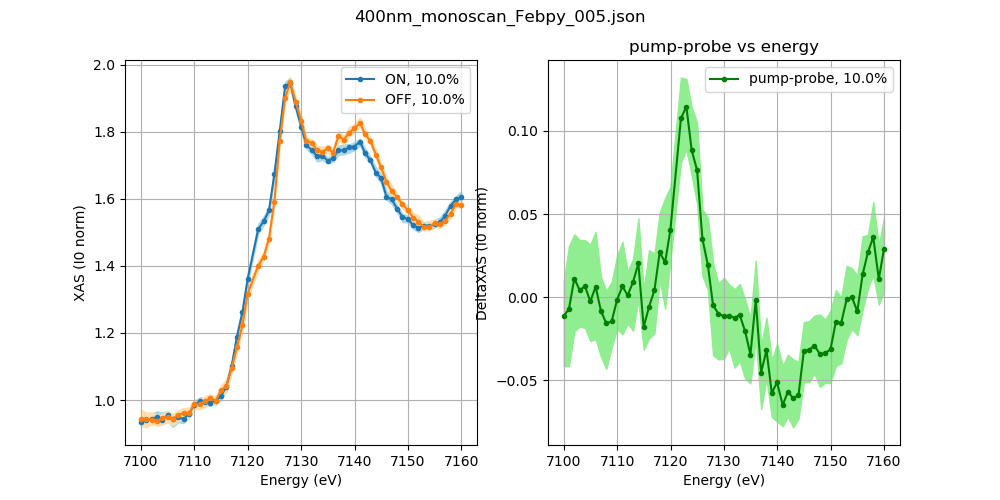

<IPython.core.display.Javascript object>


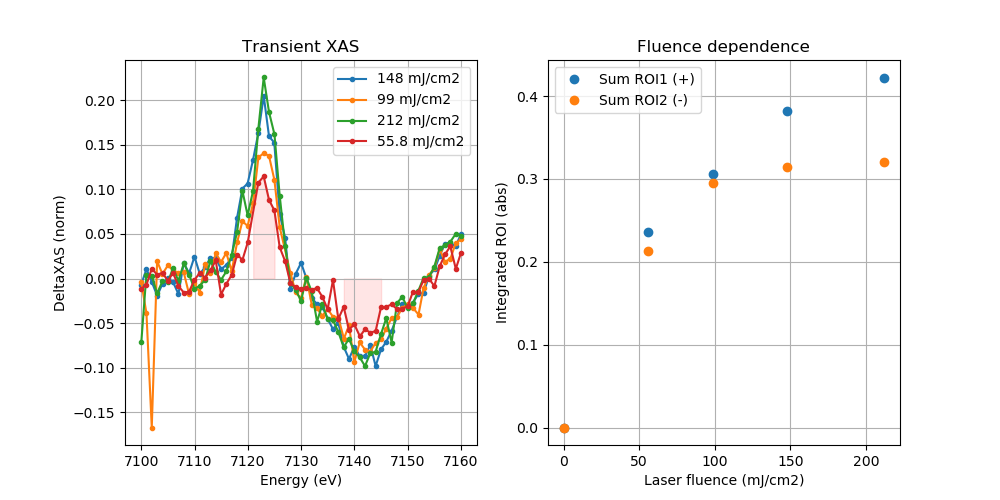

In [87]:
# DataFluo_pump_aver = np.average(DataFluo_pump_all, axis=0)
# DataFluo_unpump_aver = np.average(DataFluo_unpump_all, axis=0)
# Pump_probe_aver = np.average(Pump_probe_all, axis=0)

fig0 = plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('/')[-1], fontsize = 12)

plt.subplot(1,2,1)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_pump = -DataFluo_pump_all[3][:,0]
err_low_pump = -DataFluo_pump_all[3][:,1]
err_high_pump = -DataFluo_pump_all[3][:,2]
XAS_unpump = -DataFluo_unpump_all[3][:,0]
err_low_unpump = -DataFluo_unpump_all[3][:,1]
err_high_unpump = -DataFluo_unpump_all[3][:,2]
XAS_pump_probe = -Pump_probe_all[3][:,0]
err_low_pump_probe = -Pump_probe_all[3][:,1]
err_high_pump_probe = -Pump_probe_all[3][:,2]

plt.plot(Energy_eV_all[3], XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV_all[3], err_low_pump, err_high_pump, color='lightblue')

plt.plot(Energy_eV_all[3], XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV_all[3], err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
# plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV_all[3], XAS_pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Energy_eV_all[3],err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Energy (eV)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs energy')
plt.legend(loc="best")
plt.grid()


fluences = [0, 148, 99, 212, 55.8]
int1 = [0]
int2 = [0]

Energy_eV = np.arange(7100, 7161, 1)

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Transient XAS')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Fluence dependence')

for num, json_file in enumerate(patch):
    ax1.plot(Energy_eV_all[num], -Pump_probe_all[num][:,0], 
             label='{} mJ/cm2'.format(fluences[num+1]), marker='.')
    roi1 = np.interp(Energy_eV[21:26], Energy_eV_all[num], -Pump_probe_all[num][:,0])
    roi2 = np.interp(Energy_eV[38:46], Energy_eV_all[num], -Pump_probe_all[num][:,0])
    int1.append(np.sum(roi1) / max(-DataFluo_unpump_all[num][:,0]))
    int2.append(-np.sum(roi2) / max(-DataFluo_unpump_all[num][:,0]))
ax1.fill_between(Energy_eV[21:26],0, roi1, color='red', alpha=0.1)
ax1.fill_between(Energy_eV[38:46],0, roi2, color='red', alpha=0.1)
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("DeltaXAS (norm)")
ax1.legend(loc="best")
ax1.grid()

ax2.plot(fluences, int1, marker='o', linestyle='none', label='Sum ROI1 (+)')
ax2.plot(fluences, int2, marker='o', linestyle='none', label='Sum ROI2 (-)')
ax2.set_xlabel('Laser fluence (mJ/cm2)')
ax2.set_ylabel('Integrated ROI (abs)')
ax2.legend()
ax2.grid()

plt.show()

In [64]:
Energy_eV

array([7100])

## Load one step and check I0 filtering

In [47]:
filenumber = 31

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

step = scan[filenumber]
print (step)
resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(ffn, channel_energy)

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Energy = {} eV".format(Energy_eV[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18442/res/JF_pedestals/pedestal_20200201_2211.JF02T09V02.res.h5
jungfrau file: 11:31 01.02.2020
pedestal file: 22:23 01.02.2020
    mtime difference: -10:52:33.089839
SFDataFiles("/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001705.BSREAD.h5", "/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001705.JF02T09V02.h5"): 49 channels

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


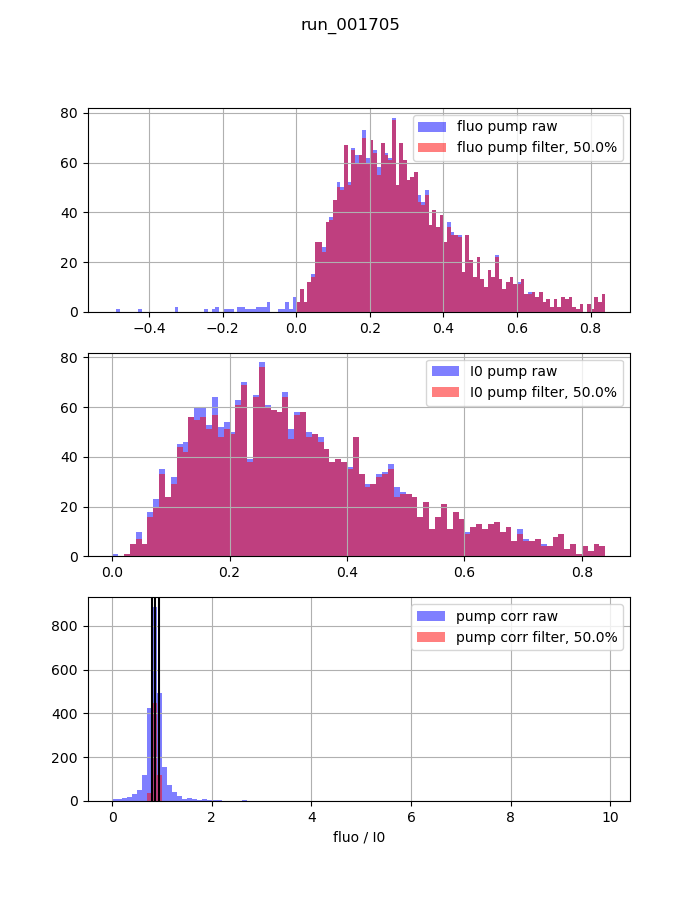

quantile range = 0.25 0.75


In [48]:
plt.figure(figsize = (7,9))
plt.suptitle(scan.files[filenumber][0].split('/')[-1].split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,10,0.1)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)

#  Check data distributions with quantiles 

In [41]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

    IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
  
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
    df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
    df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
              
    DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
    DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
    Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
        
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

print ("Job done!")


Step 81 of 81: Processing run_002221

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Job done!


<IPython.core.display.Javascript object>


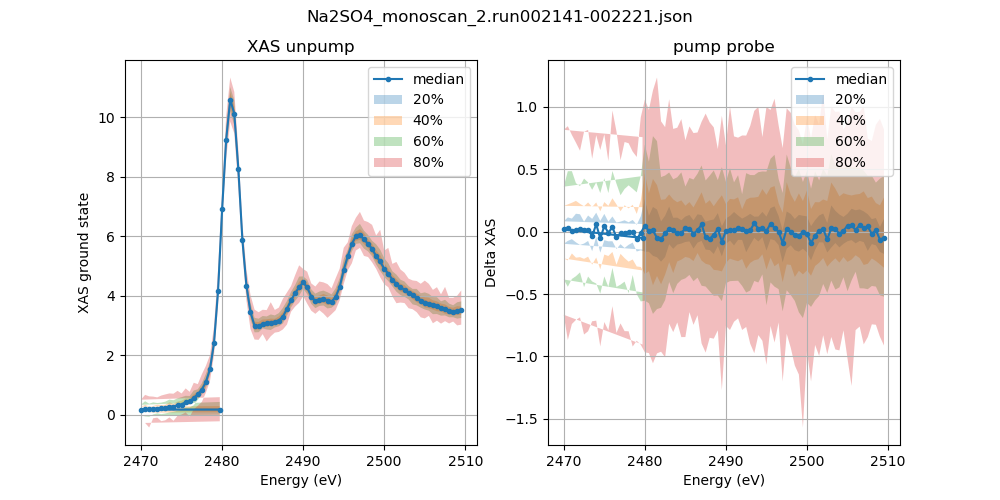

In [43]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1])

plt.subplot(1,2,1)
plt.plot(Energy_eV, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('XAS unpump')
plt.legend(loc="best")
plt.ylabel("XAS ground state")
plt.xlabel("Energy (eV)")

plt.subplot(1,2,2)
plt.plot(Energy_eV, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
plt.ylabel("Delta XAS")
plt.xlabel("Energy (eV)")

plt.show()

## cell to export data

In [ ]:
import pandas as pd
DIR_save = "/das/work/p17/p17589/Extract_data_MbNo/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'pump_probe': Pump_probe_15uJ,
    'signal_on' : DataFluo_pump_15uJ,
    'signal_off' : DataFluo_unpump_15uJ,
}).to_csv(file2save,index=False)